<a href="https://colab.research.google.com/github/ljy9969/Study/blob/master/0419_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Yahoo Finance에서 가져온 5년치 삼성전자 주식 데이터로 주가 예측하기

Time Period : Apr 19, 2017 - Apr 19, 2022

https://finance.yahoo.com/quote/005930.KS/history?period1=1492560000&period2=1650326400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/실습/005930.KS.csv')
data.head()
# data.info()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-19,41300.0,41420.0,40900.0,40900.0,35612.234375,11762900
1,2017-04-20,40580.0,40800.0,40080.0,40280.0,35072.398438,21148850
2,2017-04-21,40480.0,41400.0,40480.0,40760.0,35490.328125,15130500
3,2017-04-24,41260.0,41260.0,40920.0,41240.0,35908.277344,8990150
4,2017-04-25,41460.0,42740.0,41320.0,42700.0,37179.511719,19299600


# Compute Mid Price

In [7]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows for LSTM

In [9]:
seq_len = 50 # 50일 주가로 다음날 주가를 예측
sequence_length = seq_len + 1 # window = 50일치 주가 + 다음날 주가

result = []
for index in range(len(mid_prices) - sequence_length): # batch - window
  result.append(mid_prices[index:index + sequence_length])

# Normalize Data

In [11]:
normalized_data = []
for window in result:
  normalized_window = [((float(p) / float(window[0])) -1) for p in window] # 첫 번째 window의 첫번째 요소를 기준으로(1 - 1 = 0으로 만듦) 정규화
  normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9)) # batch에서 90%를 train data로 할당
train = result[:row, :]
np.random.shuffle(train)

# trian과 test dataset의 input&output 값 정하기
x_train = train[:, :-1] # window 안의 51개의 데이터 중 50개는 학습용으로. 0 ~ 50까지 슬라이싱
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1] # 51번 째 데이터는 정답으로

x_test = result[row:, :-1] # window 안의 데이터 중 10%는 테스트용으로
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1] # test data의 정답

x_train.shape, x_test.shape

((1056, 50, 1), (117, 50, 1))

# Build a Model

In [17]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [18]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

Epoch 1/20
106/106 [==============================] - 8s 38ms/step - loss: 0.0018 - accuracy: 0.0038 - val_loss: 3.5821e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
106/106 [==============================] - 3s 28ms/step - loss: 9.4627e-04 - accuracy: 0.0038 - val_loss: 2.5279e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
106/106 [==============================] - 3s 27ms/step - loss: 7.5180e-04 - accuracy: 0.0038 - val_loss: 2.1854e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
106/106 [==============================] - 3s 28ms/step - loss: 5.2834e-04 - accuracy: 0.0038 - val_loss: 2.0386e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
106/106 [==============================] - 3s 27ms/step - loss: 4.6242e-04 - accuracy: 0.0038 - val_loss: 1.6645e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
106/106 [==============================] - 3s 27ms/step - loss: 4.1187e-04 - accuracy: 0.0038 - val_loss: 3.5612e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
106/106 [==============================] - 3s 27ms/step - loss:

# Prediction

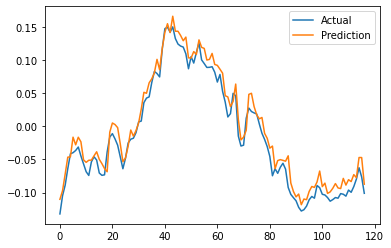

In [28]:
pred = model.predict(x_test) # 1056일 동안의 데이터로 117일의 주가 예측하기

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='Actual')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()